In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import os
import json


In [2]:
def get_daily_links(base_link):
    downloads_link = base_link.replace("newspapers","api.fdnl.patron") + '/downloads'
    response = requests.get(downloads_link)

    

    daily_links = []
    if response.status_code == 200:
        data = response.json()
        for file_name in data['pdf']:
            if file_name.endswith('pdf'):
                file_url = f"{base_link}/{file_name}"

                # Split the URL by '/'
                parts = file_url.split('/')

                # Extract the relevant parts of the URL
                id = parts[3]
                path = '/'.join(parts[5:])

                # Reformat the URL
                new_url = f'https://ufdcimages.uflib.ufl.edu/{id[:2]}/{id[2:4]}/{id[4:6]}/{id[6:8]}/{id[8:10]}/{parts[4]}/{path}'

                daily_links.append(new_url)
                break # Only add first pdf link 
    return daily_links

def get_article_links_and_dates(url, school=None):
    if school == "USC": 
        # Fetch the HTML content for the page
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all the article links and dates within the page
        article_links = {}
        for article in soup.find_all('article'):
            link = article.find('a')['href']
            date = link.split('/')[3:6]
            date = '_'.join(date)
            if date in article_links:
                article_links[date].append(link)
            else:
                article_links[date] = [link]

        return article_links
    elif school == "UF":
        import requests
        import pandas as pd
        from datetime import datetime

        api_url = "https://api.fdnl.patron.uflib.ufl.edu/serialhierarchy?bibid=UF00028290"

        response = requests.get(api_url)
        data = response.json()

        if os.path.exists('uf_article_pages.json'):
            # Open the JSON file for reading
            with open('uf_article_pages.json', 'r') as f:
               article_links = json.load(f)
        else:
            article_links = {}
        for year in data:
            # print(year)
            if int(year['key']) >= 2009:

                for month in year['values']:
                    for entry in month['values']:
                        date_str = entry['text']
                        
                        try:
                            date = datetime.strptime(date_str, '%B %d, %Y')
                            year_month_day = date.strftime('%Y_%m_%d')
                            if year_month_day in article_links:
                                print(f"Date {year_month_day} exists.")
                                continue
                            else:
                                article_links[year_month_day] = get_daily_links(url + entry['vid'])
                                print(f"Date {year_month_day} added.")
                        except ValueError:
                            try:
                                date = datetime.strptime(f"{year['key']} {month['key']} {date_str}", '%Y %B %d')
                                year_month_day = date.strftime('%Y_%m_%d')
                                if year_month_day in article_links:
                                    print(f"Date {year_month_day} exists.")
                                    continue
                                else:
                                    article_links[year_month_day] = get_daily_links(url + entry['vid'])
                                    print(f"Date {year_month_day} added.")
                                article_links[year_month_day] = get_daily_links(url + entry['vid'])
                            except ValueError as ve:
                                # if there is an error parsing the date string, print an error message and continue to the next iteration
                                print(f"{ve} Error parsing date string: {year_month_day}")
                            except TypeError as te:
                                print(f"{te} Error parsing date string: {year_month_day}") 
                        
                print(f"{year['key']} saved to json.")
                with open("uf_article_pages.json", "w") as outfile:
                    json.dump(article_links, outfile, indent=4)           
        return(article_links)



def get_article_text(url):
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")

    p_tags = soup.find_all('p')
    text = "\n".join([p.get_text() for p in p_tags])

    return text

from make_txt_entry import make_txt_entry

def make_table_entry(school_name="UF",
                     journal_name="The Independent Florida Alligator",
                     publication_date=None,
                     raw_data_directory=None,
                     reference_link=None):
    if publication_date is None or raw_data_directory is None or reference_link is None:
        return RuntimeError("Function make_table_entry has invalid arguments.")

In [3]:
article_pages = get_article_links_and_dates(url="https://newspapers.uflib.ufl.edu/UF00028290/", school="UF")

Date 2009_01_06 exists.
Date 2009_01_07 exists.
Date 2009_01_08 exists.
Date 2009_01_09 exists.
Date 2009_01_12 exists.
Date 2009_01_13 exists.
Date 2009_01_14 exists.
Date 2009_01_15 exists.
Date 2009_01_16 exists.
Date 2009_01_20 exists.
Date 2009_01_21 exists.
Date 2009_01_22 exists.
Date 2009_01_23 exists.
Date 2009_01_26 exists.
Date 2009_01_27 exists.
Date 2009_01_28 exists.
Date 2009_01_29 exists.
Date 2009_01_30 exists.
Date 2009_02_02 exists.
Date 2009_02_03 exists.
Date 2009_02_04 exists.
Date 2009_02_05 exists.
Date 2009_02_06 exists.
Date 2009_02_09 exists.
Date 2009_02_10 exists.
Date 2009_02_11 exists.
Date 2009_02_12 exists.
Date 2009_02_13 exists.
Date 2009_02_16 exists.
Date 2009_02_17 exists.
Date 2009_02_18 exists.
Date 2009_02_19 exists.
Date 2009_02_20 exists.
Date 2009_02_23 exists.
Date 2009_02_24 exists.
Date 2009_02_25 exists.
Date 2009_02_26 exists.
Date 2009_02_27 exists.
Date 2009_03_02 exists.
Date 2009_03_03 exists.
Date 2009_03_04 exists.
Date 2009_03_05 

In [4]:
print(f"There are {len(article_pages)} dates with articles")
total_size = sum([len(article_pages[key]) for key in article_pages])
print(f"There are {total_size} articles to iterate over")

There are 1804 dates with articles
There are 1804 articles to iterate over


In [5]:
from pdf_to_text import extract_pdf_text
from make_txt_entry import make_txt_entry

school_name = "UF"
for date, articles in article_pages.items():
    file_path = "journal_data/txt/"+school_name.replace(" ","_")+"/"+date+".txt"
    if(os.path.exists(file_path)):
        print(f"Date {date} already added.")
    else:
        article_text = extract_pdf_text(articles[0])
            
        make_txt_entry(school_name="UF", publication_date=date, text=article_text)
        print(f"Date {date} added.")

Date 2009_01_06 already added.
Date 2009_01_07 already added.
Date 2009_01_08 already added.
Date 2009_01_09 already added.
Date 2009_01_12 already added.
Date 2009_01_13 already added.
Date 2009_01_14 already added.
Date 2009_01_15 already added.
Date 2009_01_16 already added.
Date 2009_01_20 already added.
Date 2009_01_21 already added.
Date 2009_01_22 already added.
Date 2009_01_23 already added.
Date 2009_01_26 already added.
Date 2009_01_27 already added.
Date 2009_01_28 already added.
Date 2009_01_29 already added.
Date 2009_01_30 already added.
Date 2009_02_02 already added.
Date 2009_02_03 already added.
Date 2009_02_04 already added.
Date 2009_02_05 already added.
Date 2009_02_06 already added.
Date 2009_02_09 already added.
Date 2009_02_10 already added.
Date 2009_02_11 already added.
Date 2009_02_12 already added.
Date 2009_02_13 already added.
Date 2009_02_16 already added.
Date 2009_02_17 already added.
Date 2009_02_18 already added.
Date 2009_02_19 already added.
Date 200

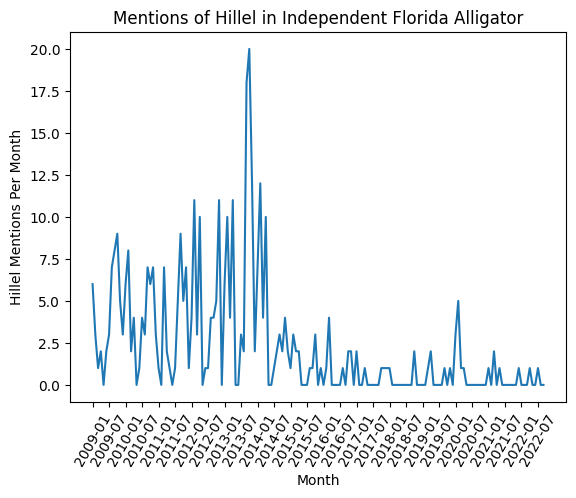

In [8]:
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

from queries import mention_tracker
from queries import hillel_counter

directory = 'journal_data/txt/UF'
UF_pipeline = [] # No pipeline or processing for now
data = []
dates = []

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        filepath = os.path.join(directory, filename)
        date_obj = datetime.strptime(filename[:-4], '%Y_%m_%d')
        dates.append(date_obj)

        with open(filepath, 'r', encoding="utf8") as file:
            contents = file.read()
        hillel_count = mention_tracker(contents, UF_pipeline, hillel_counter)
        data.append({'date': date_obj, 'count': 1 if hillel_count > 0 else 0})

df = pd.DataFrame(data)
df['month'] = df['date'].dt.to_period('M')
grouped = df.groupby('month')['count'].sum()

fig, ax = plt.subplots()
ax.plot(grouped.index.strftime('%Y-%m'), grouped.values)
plt.xticks(rotation=60)
ax.set_xlabel('Month')
ax.set_ylabel('Hillel Mentions Per Month')
ax.set_title('Mentions of Hillel in Independent Florida Alligator')

# Show only every third x-axis label
tick_locations = ax.get_xticks()
ax.set_xticks(tick_locations[::6])

plt.savefig('florida_alligator_hillel_mentions.png', bbox_inches='tight')
plt.show()
